In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np
import time
from project_utilities import ValueSet, Loss, efficiency
from sklearn.model_selection import train_test_split


In [ ]:
train_set_idx, val_set_idx=train_test_split(list(range(1,80)),test_size=15)
len(train_set_idx)

64

In [ ]:
DEVICE = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
DEVICE

'cuda:0'

In [ ]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [ ]:
random_seed= 123
NUM_EPOCHS=6
LEARNING_RATE=0.001
BATCH_SIZE=128

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)



Mounted at /content/gdrive/


In [ ]:
%cd /content/gdrive/MyDrive/Project/data

/content/gdrive/MyDrive/Project/data


In [ ]:
class MyDataset(torch.utils.data.Dataset): 
  def __init__(self, setID): 
        'Initialization' 
        npz_files_content = np.load("./Set_"+str(setID)+".npz")  
         
        self.X_set = torch.tensor(npz_files_content['X'])    
        self.y_set = torch.tensor(npz_files_content['y']) 
  def __len__(self): 
        'Denotes the total number of samples' 
        return len(self.y_set) 
  def __getitem__(self, index): 
        'Generates one sample of data' 
        # Select sample 
        X = self.X_set[index] 
        y = self.y_set[index] 
        return X, y

In [ ]:
####################################################
##### Training and evaluation wrappers
###################################################
def train(model, num_epochs,
          learning_rate=0.01, seed=123, batch_size=128):
          
  
    # print(1)
    cost = []
    torch.manual_seed(seed)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1,mode='max',verbose=True)
    for e in range(1,num_epochs):
      # print(2)
      batch_num = 0
      for setID in train_set_idx:
          train_set = MyDataset(setID) # removed + 1
          train_generator = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True,drop_last=True)
          # print(setID)
          for X_train, y_train in train_generator:
            X_train=X_train.to(DEVICE)
            y_train=y_train.to(DEVICE)
            batch_num = batch_num + 1
            #### Compute outputs ####
            yhat = model(X_train)
            # print(3)
            loss = loss_model.forward(yhat, y_train)
            #### Reset gradients from previous iteration ####
            optimizer.zero_grad()
            #### Compute gradients ####
            loss.backward()
            #### Update weights ####
            optimizer.step()
            # print(4)
            #### Logging ####
            with torch.no_grad():
                yhat = model.forward(X_train)
                curr_loss = loss_model.forward(yhat, y_train)
                print('Epoch ID: %d ' % e, end="")
                print('  Set ID: %d' % setID, end="")
                print('  Batch ID: %d' % batch_num, end="")
                print(' | Loss: %.5f' % curr_loss)
                cost.append(curr_loss)
    return cost


In [ ]:
class Trim(torch.nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :16000]

In [ ]:

class Resnet10(torch.nn.Module):

    def __init__(self):
        super(Resnet10, self).__init__()

        self.block_1 = torch.nn.Sequential(
                torch.nn.Conv1d(in_channels=1,
                                out_channels=2,
                                kernel_size=2,
                                stride=1,
                                padding=0),
                torch.nn.BatchNorm1d(2),
                # torch.nn.MaxPool2d(kernel_size=2),
                torch.nn.ReLU(inplace=True),

                torch.nn.Conv1d(in_channels=2,
                                out_channels=1,
                                kernel_size=1,
                                stride=1,
                                padding=1),
                Trim(),                
                torch.nn.BatchNorm1d(1)
                
        )
        self.block_2 = torch.nn.Sequential(
                torch.nn.Conv1d(in_channels=1,
                                out_channels=2,
                                kernel_size=2,
                                stride=1,
                                padding=0),
                torch.nn.BatchNorm1d(2),
                # torch.nn.MaxPool2d(kernel_size=2),
                torch.nn.ReLU(inplace=True),

                torch.nn.Conv1d(in_channels=2,
                                out_channels=1,
                                kernel_size=2,
                                stride=1,
                                padding=1),
                torch.nn.BatchNorm1d(1)
        )
        self.block_3 = torch.nn.Sequential(
                torch.nn.Conv1d(in_channels=1,
                                out_channels=2,
                                kernel_size=1,
                                stride=1,
                                padding=0),
                torch.nn.BatchNorm1d(2),
                torch.nn.MaxPool1d(kernel_size=2),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv1d(in_channels=2,
                                out_channels=1,
                                kernel_size=2,
                                stride=1,
                                padding=1),
                torch.nn.MaxPool1d(kernel_size=2),
                torch.nn.BatchNorm1d(1)
        )
        # for m in self.modules():
        #   if isinstance(m, torch.nn.Linear):
        #     torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        #     if m.bias is not None:
        #       m.bias.detach().zero_()
          


        

        
    def forward(self, x):
        n,h,w=x.shape
        x=x.view(n,1,h*w)
        # print(x.shape)
        shortcut = x
        x = self.block_1(x)
        # print(x.shape)
        x = torch.nn.functional.relu(x + shortcut)
        # print(x.shape)
        n,c,w=x.shape
        x=x.view(n,1,w)
        shortcut = x
        x = self.block_2(x)
        # print(x.shape)
        x = torch.nn.functional.relu(x + shortcut)
        # print(x.shape)
        x=self.block_3(x)
        logits=torch.nn.functional.relu(x)
        return logits.view(-1, 4000)

    


In [ ]:
model = Resnet10()
model=model.to(DEVICE)
loss_model = Loss(0.00001)
cost = train(model,
             num_epochs=4,
             learning_rate=0.001,
             seed=123, batch_size=1024)

Epoch ID: 1   Set ID: 34  Batch ID: 1 | Loss: 0.74637
Epoch ID: 1   Set ID: 34  Batch ID: 2 | Loss: 0.72212
Epoch ID: 1   Set ID: 34  Batch ID: 3 | Loss: 0.73849
Epoch ID: 1   Set ID: 34  Batch ID: 4 | Loss: 0.72256
Epoch ID: 1   Set ID: 79  Batch ID: 5 | Loss: 0.71264
Epoch ID: 1   Set ID: 79  Batch ID: 6 | Loss: 0.70491
Epoch ID: 1   Set ID: 79  Batch ID: 7 | Loss: 0.70257
Epoch ID: 1   Set ID: 79  Batch ID: 8 | Loss: 0.70231
Epoch ID: 1   Set ID: 55  Batch ID: 9 | Loss: 0.66820
Epoch ID: 1   Set ID: 55  Batch ID: 10 | Loss: 0.67136
Epoch ID: 1   Set ID: 55  Batch ID: 11 | Loss: 0.65955
Epoch ID: 1   Set ID: 55  Batch ID: 12 | Loss: 0.63238
Epoch ID: 1   Set ID: 60  Batch ID: 13 | Loss: 0.63194
Epoch ID: 1   Set ID: 60  Batch ID: 14 | Loss: 0.61416
Epoch ID: 1   Set ID: 60  Batch ID: 15 | Loss: 0.62952
Epoch ID: 1   Set ID: 60  Batch ID: 16 | Loss: 0.61189
Epoch ID: 1   Set ID: 27  Batch ID: 17 | Loss: 0.60833
Epoch ID: 1   Set ID: 27  Batch ID: 18 | Loss: 0.61464
Epoch ID: 1   Set I

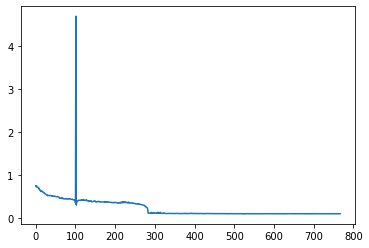

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
a=torch.tensor(cost)
cost1=a.cpu().numpy()
plt.plot(cost1)

In [ ]:
def validate(model): 
  
  
    loss_val = [] 
    eff = ValueSet(0, 0, 0, 0) 
    # switch to evaluate mode 
    model.eval() 
    with torch.no_grad():
        for setID in val_set_idx: 
          val_set = MyDataset(setID+1) 
          val_generator = torch.utils.data.DataLoader(val_set,  
                                                      batch_size=5000,  
                                                      shuffle=True) 
          print(setID) 
          for X_val, y_val in val_generator: 
            X_val=X_val.to(DEVICE)
            y_val=y_val.to(DEVICE)
            # Forward pass 
            val_outputs = model(X_val) 
            loss_output = loss_model.forward(val_outputs, y_val) 
            loss_val.append(loss_output) 
            for label, output in zip(y_val.cpu().numpy(), val_outputs.cpu().numpy()):
                eff += efficiency(label, output, difference = 5.0,  
                                  threshold = 1e-2, integral_threshold = 0.2,  
                                  min_width = 3) 
    return sum(loss_val)/len(loss_val), eff.eff_rate, eff.fp_rate

In [ ]:
loss_val, eff_rate, fp_rate = validate(model) 
print('Loss: %0.3f ' % loss_val, end="")
print('  Efficiency: %0.3f' % eff_rate, end="") 
print('  False positive rate: %0.3f' % fp_rate) 


54
72
52
77
63
58
74
6
18
46
65
33
38
48
19
Loss: 0.096   Efficiency: 0.000  False positive rate: 0.000


In [ ]:
model.eval()

Resnet10(
  (block_1): Sequential(
    (0): Conv1d(1, 2, kernel_size=(2,), stride=(1,))
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(2, 1, kernel_size=(1,), stride=(1,), padding=(1,))
    (4): Trim()
    (5): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block_2): Sequential(
    (0): Conv1d(1, 2, kernel_size=(2,), stride=(1,))
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(2, 1, kernel_size=(2,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block_3): Sequential(
    (0): Conv1d(1, 2, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU(inpl

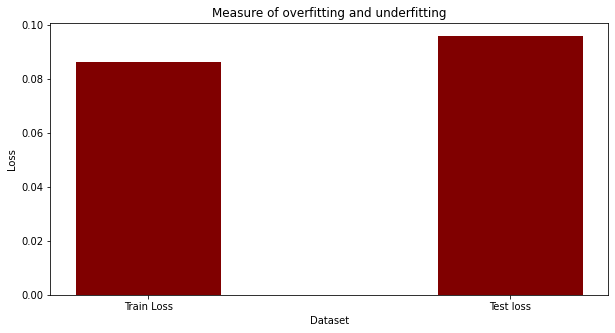

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

 
  
# creating the dataset
data = {'Train Loss':0.08616, 'Test loss':0.096}
TrainTest = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(TrainTest, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Dataset")
plt.ylabel("Loss")
plt.title("Measure of overfitting and underfitting")
plt.show()

#Saving the model

In [ ]:
torch.save(model.state_dict(),'M14993314_model.pt')

In [ ]:
model2=Resnet10()
model3=model2.to(DEVICE)
loss_model = Loss(0.00001)

#Loading the model

In [ ]:
model3.load_state_dict(torch.load('M14993314_model.pt'))

<All keys matched successfully>

In [ ]:
def validate(model): 
  
    loss_val = [] 
    eff = ValueSet(0, 0, 0, 0) 
    # switch to evaluate mode 
    model.eval() 
    with torch.no_grad():
        for setID in val_set_idx: 
          val_set = MyDataset(setID+1) 
          val_generator = torch.utils.data.DataLoader(val_set,  
                                                      batch_size=5000,  
                                                      shuffle=True) 
          print(setID) 
          for X_val, y_val in val_generator: 
            X_val=X_val.to(DEVICE)
            y_val=y_val.to(DEVICE)
            # Forward pass 
            val_outputs = model(X_val) 
            loss_output = loss_model.forward(val_outputs, y_val) 
            loss_val.append(loss_output) 
            for label, output in zip(y_val.cpu().numpy(), val_outputs.cpu().numpy()):
                eff += efficiency(label, output, difference = 5.0,  
                                  threshold = 1e-2, integral_threshold = 0.2,  
                                  min_width = 3) 
    return sum(loss_val)/len(loss_val), eff.eff_rate, eff.fp_rate

In [ ]:
loss_val, eff_rate, fp_rate = validate(model=model2) 
print('Loss: %0.3f ' % loss_val, end="")

54
72
52
77
63
58
74
6
18
46
65
33
38
48
19
Loss: 0.096 

#Checking the impact of sample size on validation set loss

In [ ]:
def train(model,train_set_idx, num_epochs,
          learning_rate=0.01, seed=123, batch_size=128):
    cost = []
    
    torch.manual_seed(seed)
    
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    
    for e in range(1,num_epochs):
      batch_num = 0
      for setID in train_set_idx:
          train_set = MyDataset(setID+1)
          train_generator = torch.utils.data.DataLoader(train_set, 
                                                        batch_size=batch_size, 
      shuffle=True)
          print(setID)
          for X_train, y_train in train_generator:
            X_train=X_train.to(DEVICE)
            y_train=y_train.to(DEVICE)
            batch_num = batch_num + 1
            #### Compute outputs ####
            yhat = model(X_train)
            loss = loss_model.forward(yhat, y_train)
            optimizer.zero_grad()
            
            #### Compute gradients ####
            loss.backward()
            
            #### Update weights ####
            optimizer.step()
            #### Logging ####
            with torch.no_grad():
                yhat = model.forward(X_train)
                curr_loss = loss_model.forward(yhat, y_train)
                cost.append(curr_loss)
    return cost

In [ ]:
def validate(model,val_set_idx):
    loss_val = []
    eff = ValueSet(0, 0, 0, 0)
    # switch to evaluate mode
    model.eval()
    with torch.no_grad():
        for setID in val_set_idx:
          val_set = MyDataset(setID+1)
          val_generator = torch.utils.data.DataLoader(val_set, 
                                                      batch_size=1024, 
    shuffle=True)
          # print(setID)
          for X_val, y_val in val_generator:
            X_val=X_val.to(DEVICE)
            y_val=y_val.to(DEVICE)
            # Forward pass
            val_outputs = model(X_val)
            loss_output = loss_model.forward(val_outputs, y_val)
            loss_val.append(loss_output)
            for label, output in zip(y_val.cpu().numpy(), val_outputs.cpu().numpy()):
                eff += efficiency(label, output, difference = 5.0, 
                                  threshold = 1e-2, integral_threshold = 0.2, 
                                  min_width = 3)
    return sum(loss_val)/len(loss_val), eff.eff_rate, eff.fp_rate

In [ ]:
a=[15,24,40,50]
train_cost=[]
test_cost=[]
for i in a:
  train_set_idx, val_set_idx=train_test_split(list(range(1,80)),test_size=i)
  torch.manual_seed(123)
  model = Resnet10()
  model=model.to(DEVICE)
  # loss_model = Loss(0.00001)
  cost = train(model,train_set_idx,
             num_epochs=3,
             learning_rate=0.001,
             seed=123, batch_size=128)
  b=torch.tensor(cost)
  cost1=b.cpu().numpy()
  train_cost.append(cost1[-1])
  loss_val, eff_rate, fp_rate = validate(model,val_set_idx)
  loss_test=loss_val.cpu().numpy()
  loss_test
  test_cost.append(loss_test)

37
36
79
71
77
30
55
46
62
44
67
23
32
66
24
35
27
26
39
4
57
58
38
22
17
49
76
16
19
63
42
40
64
73
47
5
53
60
70
43
6
9
50
45
15
41
56
33
13
54
65
75
72
10
29
28
1
21
59
61
68
18
20
74
37
36
79
71
77
30
55
46
62
44
67
23
32
66
24
35
27
26
39
4
57
58
38
22
17
49
76
16
19
63
42
40
64
73
47
5
53
60
70
43
6
9
50
45
15
41
56
33
13
54
65
75
72
10
29
28
1
21
59
61
68
18
20
74
72
39
15
5
29
65
16
66
55
25
79
68
33
44
64
12
34
41
78
32
69
63
4
6
17
48
56
23
8
10
74
37
3
22
50
35
1
71
61
19
43
36
28
24
58
67
51
21
60
40
14
18
9
11
42
72
39
15
5
29
65
16
66
55
25
79
68
33
44
64
12
34
41
78
32
69
63
4
6
17
48
56
23
8
10
74
37
3
22
50
35
1
71
61
19
43
36
28
24
58
67
51
21
60
40
14
18
9
11
42
75
55
24
32
35
64
37
47
41
38
57
62
49
28
9
22
25
26
5
8
21
23
15
67
1
59
48
51
42
63
53
7
52
61
6
18
13
16
14
75
55
24
32
35
64
37
47
41
38
57
62
49
28
9
22
25
26
5
8
21
23
15
67
1
59
48
51
42
63
53
7
52
61
6
18
13
16
14
64
45
24
58
36
6
63
10
48
13
51
19
38
75
29
70
37
62
57
50
47
18
28
55
31
2
34
65
35
64


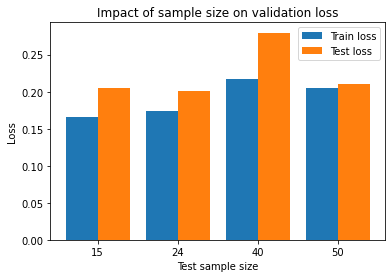

In [ ]:
X = ['15','24','40','50']
f = train_cost
g = test_cost
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, f, 0.4, label = 'Train loss')
plt.bar(X_axis + 0.2, g, 0.4, label = 'Test loss')
  
plt.xticks(X_axis, X)
plt.xlabel("Test sample size")
plt.ylabel("Loss")
plt.title("Impact of sample size on validation loss")
plt.legend()
plt.show()